C:\Users\Sai\AppData\Local\Temp\ipykernel_40176\1452805046.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)

Loaded model 1/20: saved_models/skeptic_v10\skeptic_v10_a_finetuned.pth
Loaded model 2/20: saved_models/skeptic_v10\skeptic_v10_b_finetuned.pth
Loaded model 3/20: saved_models/skeptic_v10\skeptic_v10_c_finetuned.pth
Loaded model 4/20: saved_models/skeptic_v10\skeptic_v10_d_finetuned.pth
Loaded model 5/20: saved_models/skeptic_v10\skeptic_v10_e_finetuned.pth
Loaded model 6/20: saved_models/skeptic_v10\skeptic_v10_f_finetuned.pth
Loaded model 7/20: saved_models/skeptic_v10\skeptic_v10_g_finetuned.pth
Loaded model 8/20: saved_models/skeptic_v10\skeptic_v10_h_finetuned.pth
Loaded model 9/20: saved_models/skeptic_v10\skeptic_v10_i_finetuned.pth
Loaded model 10/20: saved_models/skeptic_v10\skeptic_v10_j_finetuned.pth
Loaded model 11/20: saved_models/skeptic_v10\skeptic_v10_k_finetuned.pth
Loaded model 12/20: saved_models/skeptic_v10\skeptic_v10_l_finetuned.pth
Loaded model 13/20: saved_models/skeptic_v10\skeptic_v10_m_finetuned.pth
Loaded model 14/20: saved_models/skeptic_v10\skeptic_v10_n_f

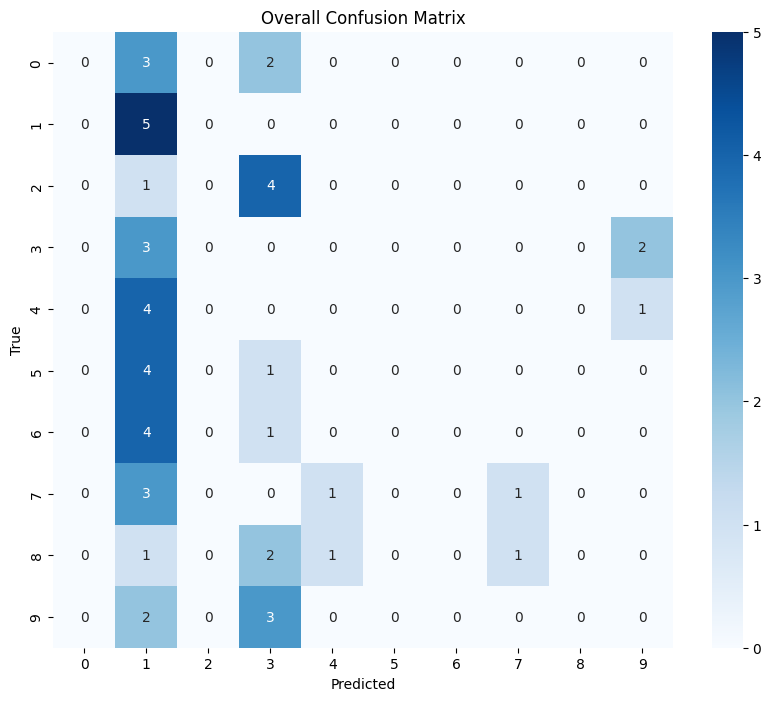

Accuracy: 0.12
Most discriminable digit: 1
Most confusable digit: 0

Results for standard images


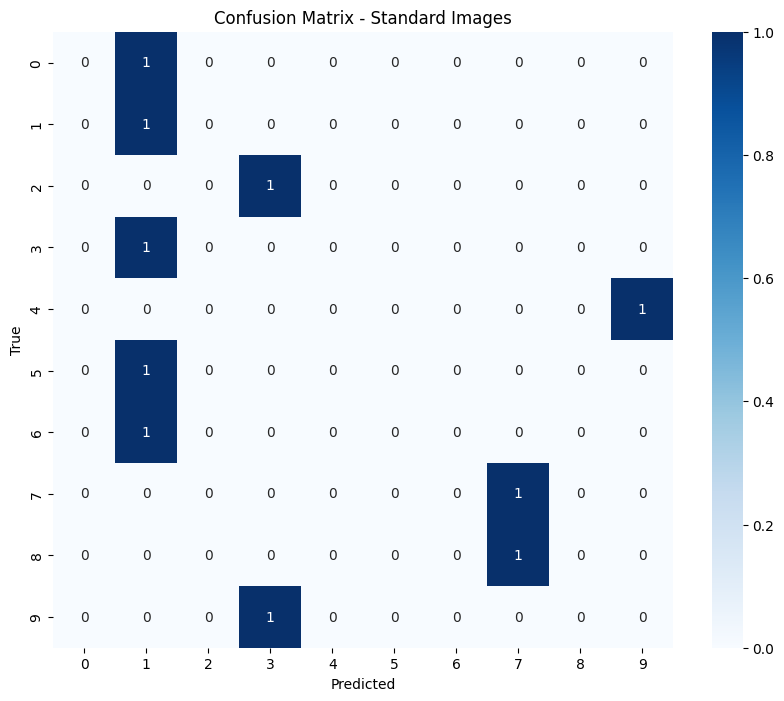

Accuracy: 0.20
Most discriminable digit: 1
Most confusable digit: 0

Results for rotated images


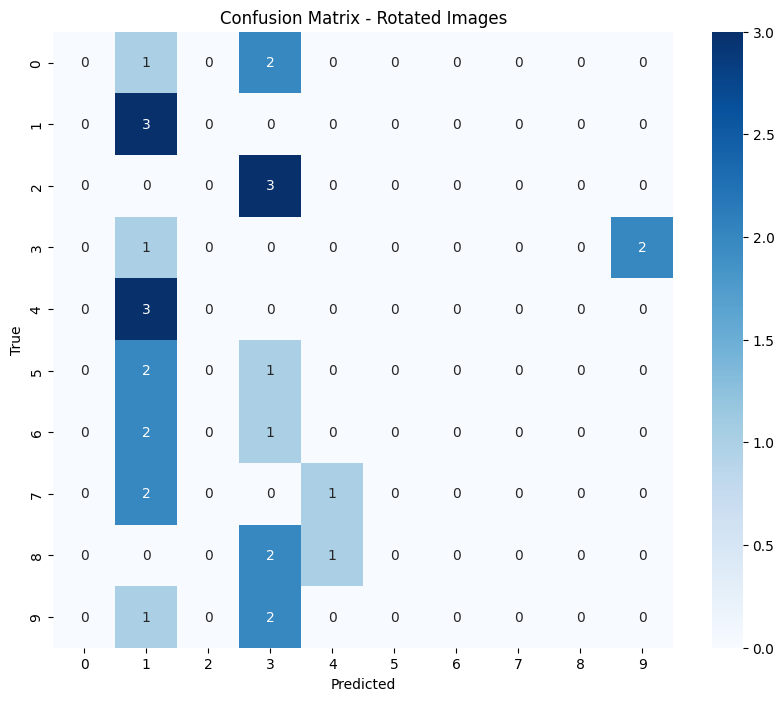

Accuracy: 0.10
Most discriminable digit: 1
Most confusable digit: 0

Results for cursive images


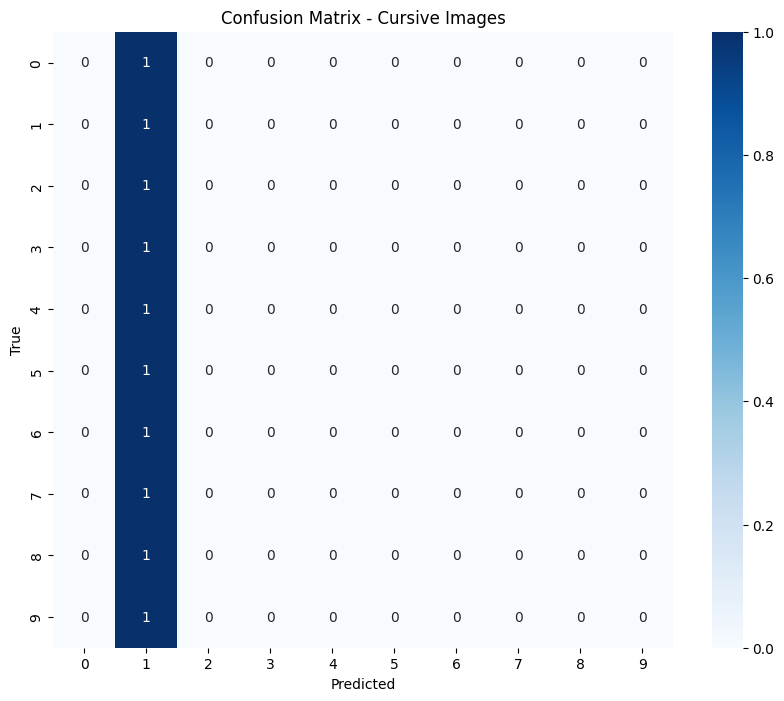

Accuracy: 0.10
Most discriminable digit: 1
Most confusable digit: 0


In [8]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image
import string

# Import your models
from mnist_skeptic_v9 import skeptic_v9  # Ensure this path is correct

# Define the transformation for images
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CompositeDataset(Dataset):
    def __init__(self, folder_path):
        self.images = []
        self.labels = []
        self.filenames = []
        self.types = []  # New attribute to store image types
        
        for filename in os.listdir(folder_path):
            if filename.endswith('.png'):
                img_path = os.path.join(folder_path, filename)
                img = Image.open(img_path).convert('L')
                img_tensor = transform(img)
                
                try:
                    # Extract true label from filename
                    label = int(filename.split('_')[2].split('.')[0])
                    
                    # Determine image type
                    if 'cursive' in filename:
                        img_type = 'cursive'
                    elif 'angle' in filename:
                        img_type = 'rotated'
                    else:
                        img_type = 'standard'
                    
                    self.images.append(img_tensor)
                    self.labels.append(label)
                    self.filenames.append(filename)
                    self.types.append(img_type)
                except (IndexError, ValueError) as e:
                    print(f"Error processing file {filename}: {str(e)}")
        
        if not self.images:
            raise ValueError(f"No valid images found in {folder_path}")
        
        self.images = torch.stack(self.images)
        self.labels = torch.tensor(self.labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx], self.filenames[idx], self.types[idx]

class ModelEnsemble:
    def __init__(self, models):
        self.models = models

    def __call__(self, inputs):
        outputs = [model(inputs) for model in self.models]
        return sum(outputs) / len(outputs)  # Average outputs of all models

    def eval(self):
        for model in self.models:
            model.eval()

def load_ensemble_models(model_class, folder_path, num_models=20, device='cpu'):
    models = []
    
    for idx, letter in enumerate(string.ascii_lowercase[:num_models]):
        model = model_class()
        checkpoint_path = os.path.join(folder_path, f'skeptic_v10_{letter}_finetuned.pth')
        
        try:
            if not os.path.exists(checkpoint_path):
                raise FileNotFoundError(f"Model checkpoint not found: {checkpoint_path}")
            
            state_dict = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            models.append(model)
            
            print(f"Loaded model {idx+1}/{num_models}: {checkpoint_path}")
        except Exception as e:
            print(f"Error loading model {idx+1}/{num_models}: {str(e)}")
    
    if not models:
        raise ValueError("No models were successfully loaded.")
    
    ensemble = ModelEnsemble(models)
    ensemble.eval()
    return ensemble

def evaluate(model, data_loader, device):
    all_predictions = []
    all_labels = []
    all_types = []
    
    with torch.no_grad():
        for batch_images, batch_labels, _, batch_types in data_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            outputs = model(batch_images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
            all_types.extend(batch_types)
    
    return all_predictions, all_labels, all_types

def create_confusion_matrix(true_labels, predictions, title):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Find most discriminable digit
    correct_per_digit = np.diag(cm)
    most_discriminable = np.argmax(correct_per_digit)
    print(f"Most discriminable digit: {most_discriminable}")
    
    # Find most confusable digit
    confusion_per_digit = np.sum(cm, axis=1) - correct_per_digit
    most_confusable = np.argmax(confusion_per_digit)
    print(f"Most confusable digit: {most_confusable}")

# Load the ensemble model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble = load_ensemble_models(skeptic_v9, 'saved_models/skeptic_v10', num_models=20, device=device)
print("Ensemble loaded successfully.")

# Folders containing composite images
folders = ['composite_images_2000_trials']

all_predictions = []
all_labels = []
all_types = []

for folder in folders:
    folder_path = os.path.join(os.getcwd(), folder)
    if os.path.exists(folder_path):
        print(f"\nProcessing {folder}")
        dataset = CompositeDataset(folder_path)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
        
        predictions, labels, types = evaluate(ensemble, dataloader, device)
        
        all_predictions.extend(predictions)
        all_labels.extend(labels)
        all_types.extend(types)
    else:
        print(f"Folder not found: {folder}")

# Create overall confusion matrix
print("\nOverall Results")
create_confusion_matrix(all_labels, all_predictions, "Overall Confusion Matrix")

# Create confusion matrices for each image type
for img_type in ['standard', 'rotated', 'cursive']:
    type_indices = [i for i, t in enumerate(all_types) if t == img_type]
    type_labels = [all_labels[i] for i in type_indices]
    type_predictions = [all_predictions[i] for i in type_indices]
    
    print(f"\nResults for {img_type} images")
    create_confusion_matrix(type_labels, type_predictions, f"Confusion Matrix - {img_type.capitalize()} Images")